In [2]:
import pandas as pd
import datetime as dt

In [3]:
data=pd.read_csv('online_retail_II - Year 2009-2010.csv')

In [4]:
################################  RFM ANALYSIS

df=pd.DataFrame(data)

In [5]:
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,12/1/09 7:45,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,12/1/09 7:45,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,12/1/09 7:45,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,12/1/09 7:45,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,12/1/09 7:45,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,12/9/10 20:01,2.95,17530.0,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,12/9/10 20:01,3.75,17530.0,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,12/9/10 20:01,3.75,17530.0,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,12/9/10 20:01,3.75,17530.0,United Kingdom


In [6]:
df['totalPrice']=data['Quantity']*data['Price']
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])
today=dt.datetime(2023,6,18)
print(today)

2023-06-18 00:00:00


In [7]:
df=df[df['Quantity']>0]
df=df[df['totalPrice']>0]

In [8]:
df_recency = df.groupby(by='Customer ID',
                        as_index=False)['InvoiceDate'].max()
df_recency.columns = ['Customer ID', 'LastPurchaseDate']
recent_date = df_recency['LastPurchaseDate'].max()
df_recency['Recency'] = df_recency['LastPurchaseDate'].apply(
    lambda x: (recent_date - x).days)
df_recency.head()

,Customer ID,LastPurchaseDate,Recency
0,12346.0,2010-06-28 13:53:00,164
1,12347.0,2010-12-07 14:57:00,2
2,12348.0,2010-09-27 14:59:00,73
3,12349.0,2010-10-28 08:23:00,42
4,12351.0,2010-11-29 15:23:00,10


In [9]:
frequency_df = df.drop_duplicates().groupby(
by=['Customer ID'], as_index=False)['InvoiceDate'].count()
frequency_df.columns = ['Customer ID','Frequency']
frequency_df.head()


,Customer ID,Frequency
0,12346.0,33
1,12347.0,71
2,12348.0,20
3,12349.0,102
4,12351.0,21


In [10]:
df['totalPrice']=data['Quantity']*data['Price']
monetary_df = df.groupby(by='Customer ID', as_index=False)['totalPrice'].sum()
monetary_df.columns = ['Customer ID', 'Monetary']
monetary_df.head()


,Customer ID,Monetary
0,12346.0,372.86
1,12347.0,1323.32
2,12348.0,222.16
3,12349.0,2671.14
4,12351.0,300.93


In [11]:
rf_df = df_recency.merge(frequency_df, on='Customer ID')
rfm_df = rf_df.merge(monetary_df, on='Customer ID').drop(
columns='LastPurchaseDate')
rfm_df


,Customer ID,Recency,Frequency,Monetary
0,12346.0,164,33,372.86
1,12347.0,2,71,1323.32
2,12348.0,73,20,222.16
3,12349.0,42,102,2671.14
4,12351.0,10,21,300.93
...,...,...,...,...
4307,18283.0,17,217,641.77
4308,18284.0,66,28,461.68
4309,18285.0,295,12,427.00
4310,18286.0,111,67,1296.43


In [12]:
rfm_df['R_rank'] = rfm_df['Recency'].rank(ascending=False)
rfm_df['F_rank'] = rfm_df['Frequency'].rank(ascending=True)
rfm_df['M_rank'] = rfm_df['Monetary'].rank(ascending=True)

# normalizing the rank of the customers
rfm_df['R_rank_norm'] = (rfm_df['R_rank']/rfm_df['R_rank'].max())*100
rfm_df['F_rank_norm'] = (rfm_df['F_rank']/rfm_df['F_rank'].max())*100
rfm_df['M_rank_norm'] = (rfm_df['F_rank']/rfm_df['M_rank'].max())*100

rfm_df.drop(columns=['R_rank', 'F_rank', 'M_rank'], inplace=True)

rfm_df.head()


,Customer ID,Recency,Frequency,Monetary,R_rank_norm,F_rank_norm,M_rank_norm
0,12346.0,164,33,372.86,21.382542,41.685993,41.685993
1,12347.0,2,71,1323.32,95.957821,64.900278,64.900278
2,12348.0,73,20,222.16,38.324546,27.562616,27.562616
3,12349.0,42,102,2671.14,56.414763,75.452226,75.452226
4,12351.0,10,21,300.93,85.166960,28.838126,28.838126


In [13]:
rfm_df['RFM_Score'] = 0.15*rfm_df['R_rank_norm']+0.28 * \
rfm_df['F_rank_norm']+0.57*rfm_df['M_rank_norm']
rfm_df['RFM_Score'] *= 0.05
rfm_df = rfm_df.round(2)
rfm_df[['Customer ID', 'RFM_Score']]



,Customer ID,RFM_Score
0,12346.0,1.93
1,12347.0,3.48
2,12348.0,1.46
3,12349.0,3.63
4,12351.0,1.86
...,...,...
4307,18283.0,4.41
4308,18284.0,1.88
4309,18285.0,0.73
4310,18286.0,2.90


In [14]:
import numpy as np
rfm_df["Customer_segment"] = np.where(rfm_df['RFM_Score'] >
4.5, "Top Customers",
(np.where(
rfm_df['RFM_Score'] > 4,
"High value Customer",
(np.where(
rfm_df['RFM_Score'] > 3,
"Medium Value Customer",
np.where(rfm_df['RFM_Score'] > 1.6,
'Low Value Customers', 'Lost Customers'))))))
rfm_df[['Customer ID', 'RFM_Score', 'Customer_segment']].head(20)


,Customer ID,RFM_Score,Customer_segment
0,12346.0,1.93,Low Value Customers
1,12347.0,3.48,Medium Value Customer
2,12348.0,1.46,Lost Customers
3,12349.0,3.63,Medium Value Customer
4,12351.0,1.86,Low Value Customers
5,12352.0,1.69,Low Value Customers
6,12353.0,1.59,Lost Customers
7,12355.0,1.40,Lost Customers
8,12356.0,3.56,Medium Value Customer
9,12357.0,4.17,High value Customer


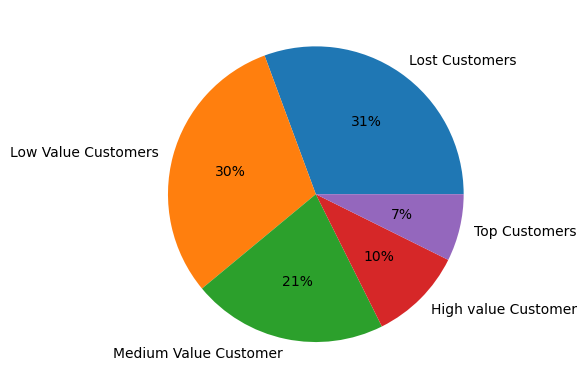

In [15]:
import matplotlib.pyplot as plt
plt.pie(rfm_df.Customer_segment.value_counts(),
labels=rfm_df.Customer_segment.value_counts().index,
autopct='%.0f%%')
plt.show()


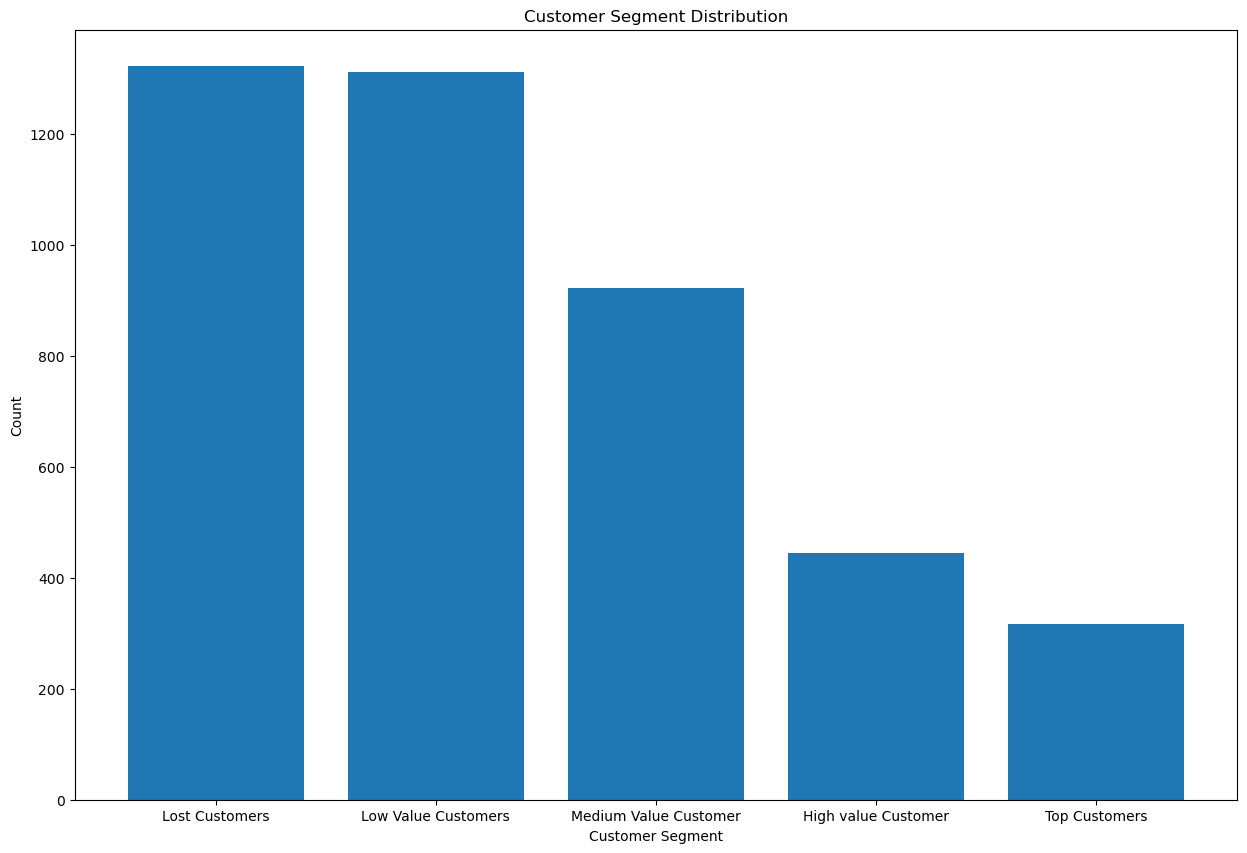

In [21]:
segment_counts = rfm_df['Customer_segment'].value_counts()
plt.figure(figsize=(15,10))
plt.bar(segment_counts.index, segment_counts.values)
plt.xlabel('Customer Segment')
plt.ylabel('Count')
plt.title('Customer Segment Distribution')
plt.show()
